# <center> Практические задания по цифровой обработке сигналов </center>
## <center> Четвертая лабораторная работа </center>
## <center> Акустические признаки </center>  
**Булаев Владимир, группа DS-22**  

In [1]:
import librosa
import numpy as np
import scipy 
import scipy.fft
import IPython.display as ipd
import matplotlib.pyplot as plt
import librosa.display
import librosa.filters
import hashlib
from glob import glob
import os
import sklearn

%matplotlib inline

In [2]:
# Функция отрисовки аудио сигнала. 
def draw_waveform(wav, sr, figsize=(14, 5)):
    # Отрисовка звукового сигнала во временной области
    plt.figure(figsize=figsize)
    librosa.display.waveplot(wav, sr=sr)
    plt.show()

In [3]:
# Для выполнения задания нам понадобится датасет yes/no. 
# Про датасет можно почитать тут https://www.openslr.org/1/

# Скачаем его
#![ ! -f  waves_yesno.tar.gz ] && wget https://www.openslr.org/resources/1/waves_yesno.tar.gz
# И распакуем
#!tar -xvzf waves_yesno.tar.gz

# P.S если у вас Windows, или по каким-либо еще причинам данные не скачались, 
# то их можно скачать руками отсюда: https://www.openslr.org/1/

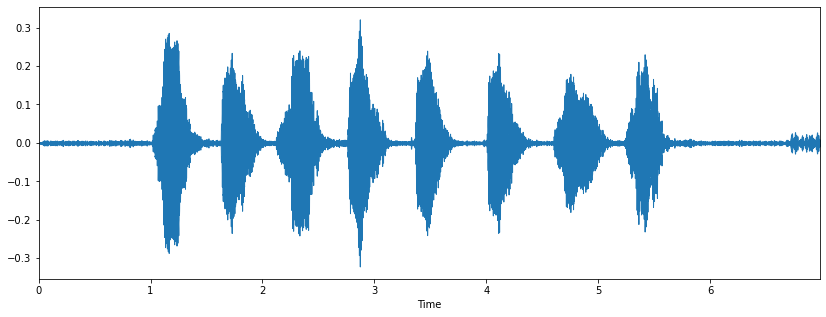

In [3]:
# Загрузим один из файлов
wav, sr = librosa.load("./waves_yesno/0_1_0_1_1_1_0_0.wav")
draw_waveform(wav, sr)
ipd.Audio(wav, rate=sr)

Как можно услышать, в этом датасете произносятся какие-то два слова (yes/no на иврите). Каждый файл состоит из 8 произнесений. Метки слов указаны в названиях файлов.

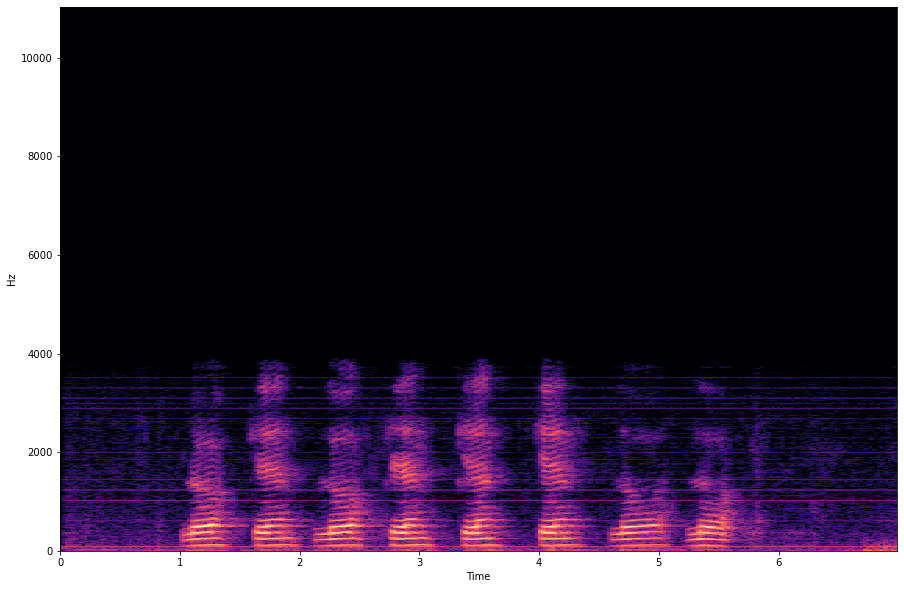

In [4]:
# Построим спектрограмму загруженной вавки
stft = librosa.stft(wav)
stft_db = librosa.amplitude_to_db(abs(stft))
plt.figure(figsize=(15,10))
librosa.display.specshow(stft_db, sr=sr, x_axis='time', y_axis='hz')

# Задание 0.1: Анализ спектрограммы (0.5 балла)
1. Посмотрите на спектрограмму и попробуйте найти признаки, по которым можно отличить произнесение "yes" от "no". 
1. В каких частотах находится основная энергия этого речевого сигнала? 

**Ответ:**  
1. Какие-либо отличительные особенности визуально выделить сложно. Возможно, у слова "yes" суммарная энергия будет больше.
2. Основная энергия данного речевого сигнала находится в диапазоне частот от 0 до 4 кГц.

# Задание 1: Мел-шкала (1 балл)
Нарисовать спектрограму в [mel-шкале](https://en.wikipedia.org/wiki/Mel_scale). 
Использовать формулу, представленную Дугласом О'Шонесси.

In [5]:
# Функция для пересчета Гц в мел
def mel(f):
    return 1127 * np.log(1 + f / 700)

# Функция для пересчета мел в Гц
def hertz(x):
    return 700 * (np.exp(x / 1127) - 1)

In [6]:
def test_mel():
    x = np.random.randint(100, size=(1000, 100))
    x_mel = mel(x)
    x_hz = 700.0 * (10.0 ** (x_mel / 2595.0) - 1.0)
    assert np.allclose(x, x_hz), "TEST Hertz -> Mel -> Hertz  failed. "
    print("Ok!")
test_mel() 

Ok!


# Мел-фильтры
Одними из наиболее популярных акустических признаков являются Filter Banks (fbanks). 
fbanks вычисляются применением нескольких (количество фильтров = количество fbanks) треугольных фильтров к мел-спектрограмме. Чтобы не делать два действия со спектрограммой, переход к мел-шкале и применение фильтров в мел-шкале можно заменить на перевод мел-фильтров в Герц-шкалу и применение их к Герц-спектрограмме.



# Задание 2 (3 балла)
Реализуйте функцию вычисления fbank. 

In [7]:
# Функция расчета банка мел-фильтров
def mel_filters(sr, n_fft, n_mels):
    # функция построения треугольных мел-фильтров в герц-шкале
    # sr - sample rate
    # n_fft - length of the FFT window 
    # n_mels - number of filters
    # return mel filters matrix. [n_mel, n_fft]
    
    # Минимальная и максимальная частоты
    fmin = 0
    fmax = sr / 2.
    # Количество используемых коэффициентов в преобразовании Фурье 
    K = n_fft // 2 + 1
    # Равномерная сетка частот в герцах
    f_arr = np.linspace(fmin, fmax, K)
    # Сетка частот в мелах. Равномерно генерируем мелы в диапазоне 0 - Max_mel и переводим в герцы.
    m_arr = hertz(np.linspace(mel(fmin), mel(fmax), n_mels + 2))

    # Расчет разности между соседними значениями в сетке мелов
    diff = np.diff(m_arr)
    # Расчет всех возможных разностей элементов сетки герц и мелов
    ramps = np.subtract.outer(m_arr, f_arr)
    
    result = np.zeros((n_mels, K))
    # Цикл по фильтрам
    for i in range(n_mels):
        lower = -ramps[i] / diff[i]
        upper = ramps[i+2] / diff[i+1]
        result[i] = np.maximum(0, np.minimum(lower, upper))
    # Нормировка данных
    enorm = 2.0 / (m_arr[2:n_mels+2] - m_arr[:n_mels])
    return result * enorm.reshape(-1, 1)

In [8]:
assert mel_filters(32, 46, 4).shape == (4, 24) and \
    mel_filters(65, 45, 5).shape == (5, 23), "Wrong shape"
assert np.allclose(mel_filters(16, 8, 4), librosa.filters.mel(16, 8, n_mels=4, htk=True))
assert np.allclose(mel_filters(8600, 512, 40), librosa.filters.mel(8600, 512, n_mels=40, htk=True))
print("All ok!")

All ok!


In [9]:
# Short-time Fourier transform - Оконное преобразование Фурье
def STFT(x, n_fft=2048, hop_length=512, window='hann'):
    # x - signal, n_fft - fft window size 
    # hop_length - step size between ffts, window - window type
    # Оконная функция
    w = scipy.signal.get_window(window, n_fft)
    # Спектр, получаемый после ДПФ, симметричен относительно середины массива.
    # Уникальными являются половина спектра плюс нулевая гармоника.
    # Чтобы не загромождать выходной массив, будем считать спектр только до середины - K
    K = n_fft // 2 + 1
    # Делаем паддинг - дополняем сигнал слева и справа размером в половину длины окна анализа.
    # Слева добавляем зеркальное отражение начальных К отсчетов (нулевой не берется) x[1:K][::-1].
    # Справа добавляем зеркальное отражение последних К отсчетов (самый последний не берется).
    padded = np.hstack([x[1:K][::-1], x, x[len(x) - K - 1:-1][::-1]])
    result = []
    i = 0
    # Пока правая граница окна анализа не перешла границу массива, двигаем окно анализа 
    while i + n_fft < len(padded):
        # Расчет БПФ дополненного сигнала, взвешенного оконной функцией
        spec = scipy.fft.fft(w * padded[i:i + n_fft])[:K]
        result.append(spec)
        i += hop_length
    return np.array(result).T

In [10]:
# Функция расчета мел-спектрограммы
def get_fbanks(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_fbanks=40):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_fbanks - number of filters
    # return fbank matrix [n_fbanks, time]
    
    # Делим на 1000, т.к. размер окна указываем в мс
    # Количество отсчетов БПФ
    n_fft = window_ms * sr // 1000
    # Шаг окна в отсчетах
    hop_length = step_mc * sr // 1000
    # Расчет спектрограммы - амплитудный спектр оконного преобразования Фурье
    spectrogram = np.abs(STFT(x = wav, n_fft = n_fft, hop_length = hop_length))
    # Расчет спектра мощности
    power_spectrum = spectrogram ** 2
    # Банк мел-фильтров
    mel_basis = mel_filters(sr, n_fft, n_fbanks)
    # Расчет мел-спектрограммы: перемножаем АЧХ каждого фильтра (матрица размера n_fbank x n_fft) 
    # со спектром мощности (матрица n_fft x time) и суммируем полдученные коэффициенты - матричное перемножение.
    # Получим матрицу размера (n_fbank x time) - мел-спектрограмму
    mel_spectrogram = np.dot(mel_basis, power_spectrum)
    return mel_spectrogram

In [11]:
def test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    fbanks_lib = librosa.feature.melspectrogram(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_fbanks, htk=True)
    fbanks = get_fbanks(wav, sr, window_ms=window_ms, step_mc=step_mc, n_fbanks=n_fbanks)
    
    if fbanks_lib.shape != fbanks.shape:
        print("TEST FAILED")
        print(f"Shape {fbanks_lib.shape} != {fbanks.shape}")
    if not np.allclose(fbanks_lib, fbanks):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(fbanks_lib - fbanks))}")
        return -1
    print("TEST PASSED")
    return 0
    assert test_fbank(wav[:sr*1], sr) == 0, "1 sec wav test failed"
    assert test_fbank(wav, sr) == 0 , "All wav test failed"
    print("All ok!")
test_fbank(wav, sr, window_ms=25, step_mc=10, n_fbanks=40)

TEST PASSED


0

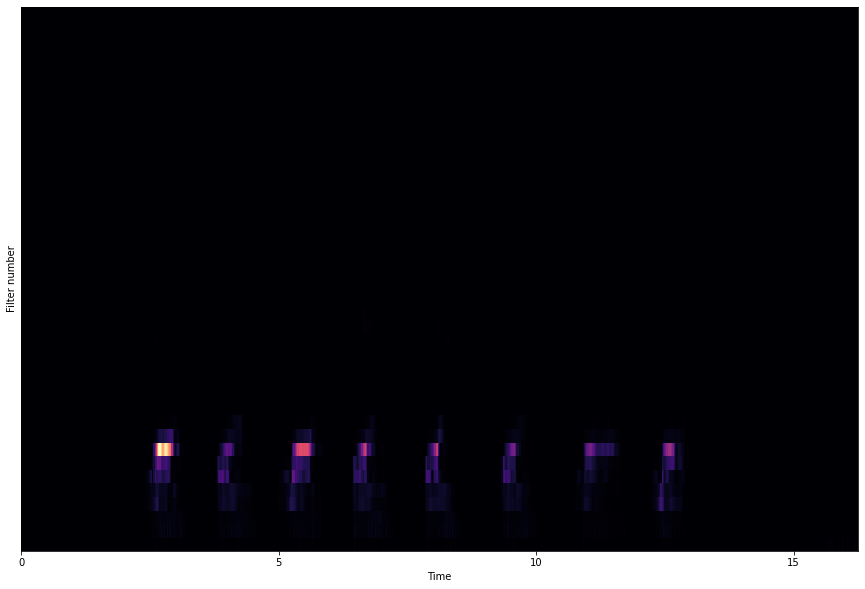

In [12]:
fbanks = get_fbanks(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(fbanks, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

# Задание 3 (3 балла)
Реализовать вычисление [mfcc](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)



In [13]:
# Функция для расчета mfcc
def get_mfcc(wav: np.ndarray, sr: int, window_ms=25, step_mc=10, n_mfcc=13):
    # wav - input signal
    # sr - sample rate
    # window_ms - window length in milliseconds
    # step_ms - stft step in milliseconds
    # n_mfcc - number of filters
    # return mfcc matrix [n_mfcc, time]
    
    # Количество мел-фильтров для расчета мел-спектрограммы   
    n_mels = 40
    # Максимальное значение логарифма спектрограммы
    max_db = 80
    # Расчте мел-спектрограммы
    mel_spectrogram = get_fbanks(wav = wav, sr = sr, window_ms=window_ms, step_mc=step_mc, n_fbanks = n_mels)
    # Логарифм значений мел-спектрограммы
    S = 10 * np.log10(mel_spectrogram)
    # Приводим к диапазону max_db
    S = np.maximum(S, S.max() - 80)
    # Вычисляем дискретное косинусное преобразование и берем первые n_mfcc значений
    result = scipy.fftpack.dct(S, axis=0, type=2, norm='ortho')[:n_mfcc]
    return result

In [14]:
def test_mfcc(wav, sr, window_ms=25, step_mc=10, n_mfcc=13):
    n_fft = window_ms * sr//1000
    hop_length = step_mc * sr//1000
    mfcc_lib = librosa.feature.mfcc(wav, sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc, n_mels = 40, htk=True)
    mfcc = get_mfcc(wav, sr, window_ms=window_ms, step_mc=step_mc, n_mfcc=n_mfcc)
    
    if mfcc_lib.shape != mfcc.shape:
        print("TEST FAILED")
        print(f"Shape {mfcc_lib.shape} != {mfcc.shape}")
    if not np.allclose(mfcc_lib, mfcc, atol=1e-04):
        print("TEST FAILED")
        print(f"Average diff is {np.mean(np.abs(mfcc_lib - mfcc))}")
        return -1
    print("TEST PASSED")
    return 0
assert test_mfcc(wav[:sr*1], sr) == 0, "1 sec wav test failed"
assert test_mfcc(wav, sr) == 0 , "All wav test failed"
print("All ok!")

TEST PASSED
TEST PASSED
All ok!


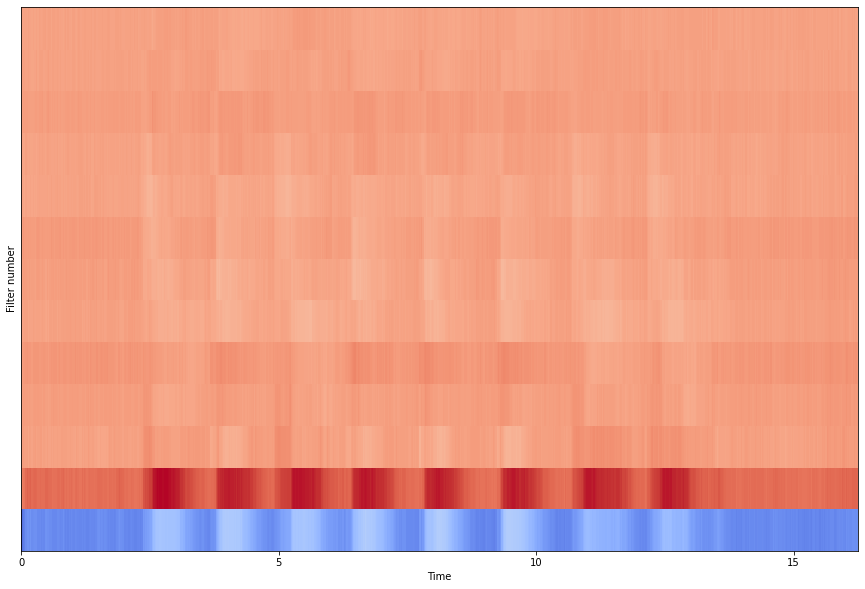

In [15]:
mfcc = get_mfcc(wav, sr)
plt.figure(figsize=(15,10))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.ylabel("Filter number")
plt.show()

In [16]:
mfcc.shape

(13, 700)

# Классификация слов
Построим простую систему, классифицирующую слова yes/no.

Загрузим весь датасет

In [17]:
def load_yn_dataset(directory):
    X, labels = [], []
    for f in glob(directory +"/*.wav"):
        name = os.path.basename(f)[:-4]
        y = [int(l) for l in name.split("_")]
        x, _ = librosa.load(f)
        X.append(x)
        labels.append(y)
        
    return X, labels
        
X, Y = load_yn_dataset("waves_yesno/")

# Удаляем из датасета некондиционные данные с индексом 21
del X[21]
del Y[21]

Отделим 20% для теста

In [18]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y,test_size=0.2, random_state=1)

# Задание *4 (1 балл)
Voice Activity Detector (VAD) определяет, есть ли речь в текущем кадре или нет.
Реализуйте простой VAD.
Настройте VAD, чтобы хорошо определялись границы слов.

In [19]:
# Функция вычисления скользящего среднего в окне длиной w
def moving_average(x, w):
    fltr = np.ones(w)
    # Свертка сигнала с фильтром
    result = np.convolve(x, fltr, 'same') / np.sum(fltr)
    # Нормируем результат к диапазону [0, 1]
    result /= result.max()
    return result

# Функция для препроцессинга звуковых данных
def preprocess(x, w):
    # Усилим сильные амплитуды и ослабим малые, а также приведем к положительному диапазону
    result = x ** 2
    # Сгладим полученный сигнал скользящим средним
    result = moving_average(result, w)
    return result

# Функция для определения, является ли текущий отсчет речью
def VAD(x, w, threshold):
    # Прдобработка данных
    wav = preprocess(x, w)
    # Все, что превышает порог, помечаем как речь
    result = (wav >= threshold).astype(int)
    # Чтобы не было дребезга метки речь/тишина, сглаживаем полученные метки
    result = moving_average(result, 200)
    # В результате сглаживания меток могли появиться дробные числ, округляем их
    result = np.where(result < 0.5, 0, 1)
    return result

Будем решать задачу во временной области. Суть подхода в следующем: возведем исходные амплитуды сигнала в квадрат. Это позволит избавиться от отрицательных чисел, а также повысит контраст между сигналом и шумом. Посмотрим на примере:

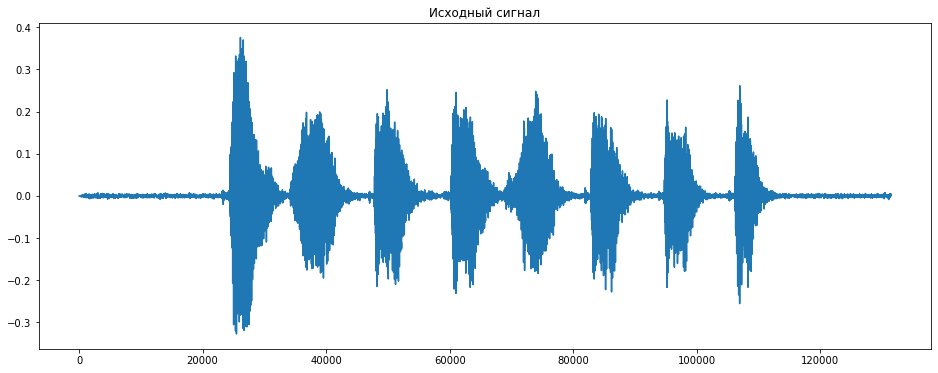

In [20]:
# Индекс обучающего массива, используемый для визуализации
IDX = 0

plt.figure(figsize = (16, 6))
plt.plot(X_train[IDX])
plt.title('Исходный сигнал')
plt.show()

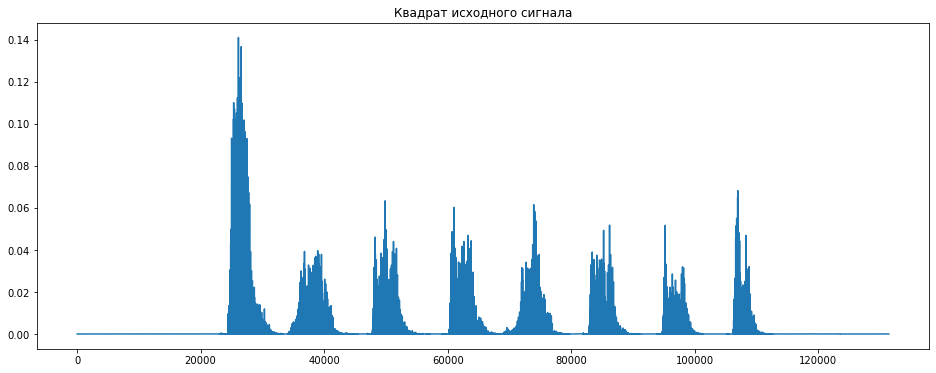

In [21]:
plt.figure(figsize = (16, 6))
plt.plot(X_train[IDX] ** 2)
plt.title('Квадрат исходного сигнала')
plt.show()

На графике видно, что в области сигнала также присутствуют низкие значения амплитуд. В таком виде подобрать порог для определение сигнала навряд ли получится. Поэтому сделаем сглаживание данных скользящим окном, при этом отнормируем результат, чтобы амплитуды были в пределах [0, 1]

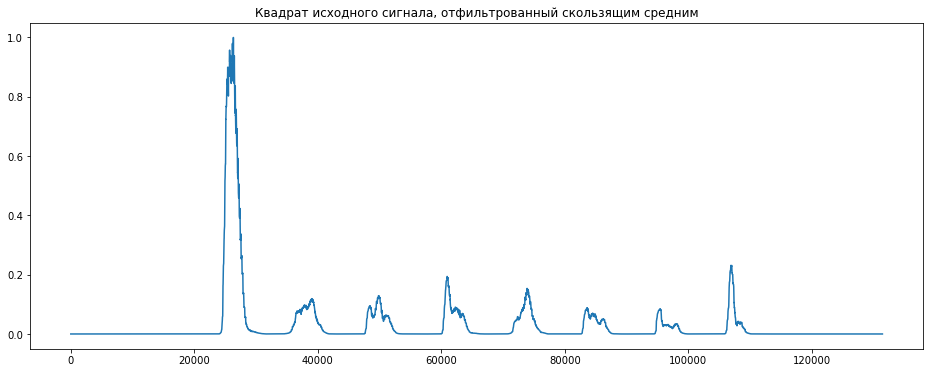

In [22]:
plt.figure(figsize = (16, 6))
plt.plot(preprocess(X_train[IDX] ** 2, 800))
plt.title('Квадрат исходного сигнала, отфильтрованный скользящим средним')
plt.show()

Теперь наши данные готовы для того, чтобы применить к ним порог амплитуды, отделяющий сигнал от шума:

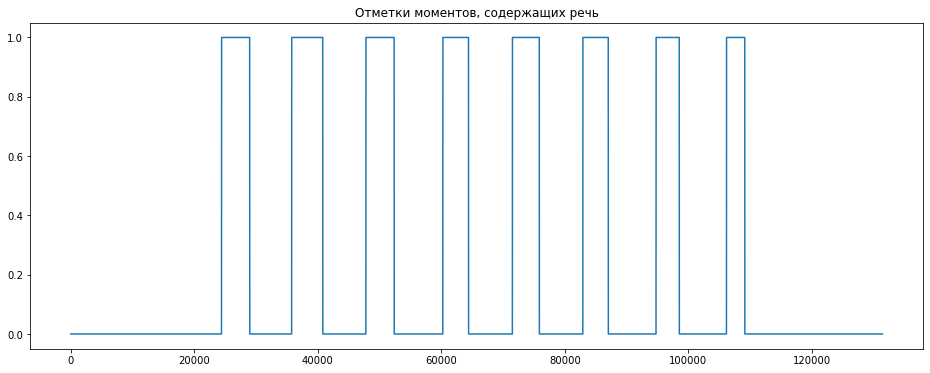

In [23]:
plt.figure(figsize = (16, 6))
plt.plot(VAD(X_train[IDX], 1000, 0.1))
plt.title('Отметки моментов, содержащих речь')
plt.show()

У предложенного подходя есть 2 гиперпараметра: ширина окна сглаживания и величина порога. Необходимо подобрать значения этих параметров на обучающей выборке. В процессе ручного анализа обучающих данных в качестве оптимальных параметров были выбраны следующие:

In [24]:
# Оптимальные значения параметров, подобранные на обучающих данных
window = 1400
threshold = 0.1

In [25]:
# Обработаем обучающий и тестовый датасет
train_VA = [VAD(x, window, threshold) for x in X_train]
test_VA  = [VAD(x, window, threshold) for x in X_test]

In [26]:
def test_VAD(VA, Y):
    def check_diff(diff, num_words):
        if diff.sum()!=0:
            print("VAD detected speech at the beginning (or end) of audio")
            return -1 
        if not (diff > 0).sum() == (diff > 0).sum() ==  num_words:
            print("Wrong number of words. Each audio contains 8 words")
            return -2
        return 0
    
    for i, (va, y) in enumerate(zip(VA, Y)):
        diff = va[1:]  - va[:-1]
        assert check_diff(diff, len(y)) == 0, f"Bad {i} example"

test_VAD(train_VA, Y_train)
test_VAD(test_VA, Y_test)

Вывод: в ходе работы предложенный подход продемонстрировал высокую точность на обучающих и тестовых данных

# Задание *5 (2 балла)
Обучите классификатор, определяющий, какое слово было сказано. Используйте VAD для разбиения входных файлов на отдельные слова. Классификацию можно сделать, например, с помощью SVM по усредненным признаки слов выделеных слов. Или любым другим удобным для вас способом. 